<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/Expression_of_genes_related_Immune_reponse_pathways_in_the_7_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Nikita Dsouza

The goal of this notebook is to show the expression of the genes in the scRNA dataset

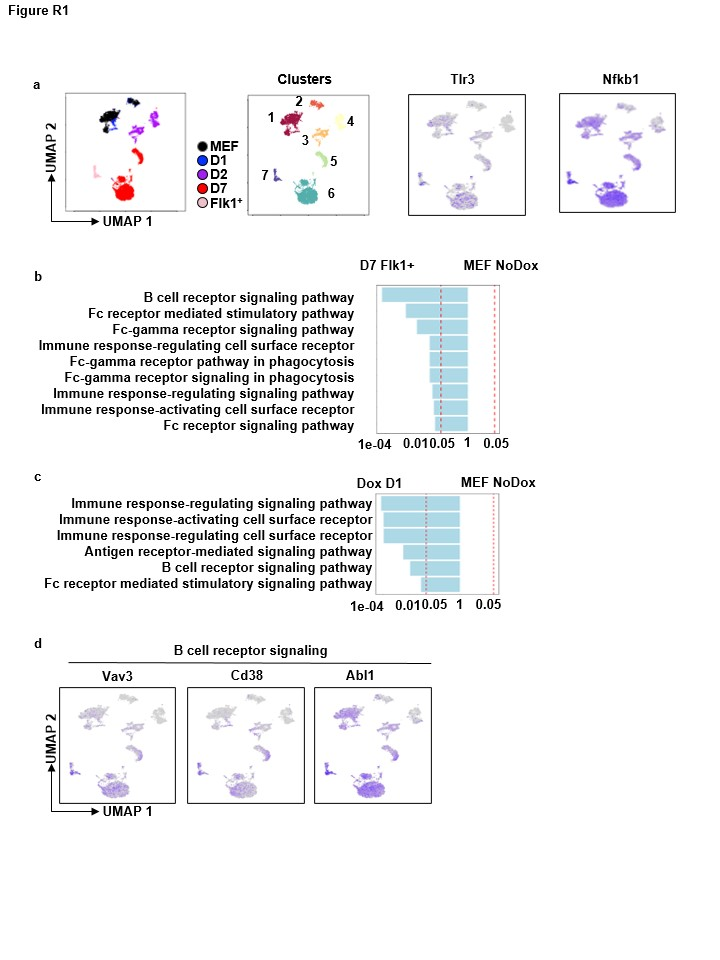

In [ ]:
start_time0 <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'rhdf5', 'SingleCellExperiment', 'limma', 'goseq', 
  'stringr', 'ggplot2', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db',
  'wordcloud', 'plotrix', 'DESeq2','fgsea','cowplot','GO.db','GOfuncR','Mus.musculus'
), Ncpus = 2)
install.packages(c('farver', "Seurat"), Ncpus = 2)
install.packages('devtools')
devtools::install_github('rstudio/reticulate')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'stringr' 'ggplot2'”
Installing package(s) 'BiocVersion', 'SummarizedExperiment', 'rhdf5',
  'SingleCellExperiment', 'limma', 'goseq',
  'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db', 'wordcloud', 'plotrix',
  'DESeq2', 'fgsea', 'cowplot', 'GO.db', 'GOfuncR', 'Mus.musculus'

also installing the dependencies ‘Rhtslib’, ‘rjson’, ‘filelock’, ‘formatR’, ‘zlibbioc’, ‘bitops’, ‘XML’, ‘Rsamtools’, ‘GenomicAlignments’, ‘restfulr’, ‘plogr’, ‘png’, ‘BiocFileCache’, ‘lambda.r’, ‘futile.options’, ‘xtable’, ‘matrixStats’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘rtracklay


✔  checking for file ‘/tmp/Rtmp5gijWE/remotes4d3dfe7335/rstudio-reticulate-277f410/DESCRIPTION’
─  preparing ‘reticulate’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘reticulate_1.22-9000.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(SummarizedExperiment)
library(RColorBrewer)
library(plyr)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(wordcloud)
library(plotrix)
library(DESeq2)
library(fgsea)
library(cowplot)
library(tidyverse)
library(magrittr)
library(GO.db)
library(GOfuncR)
library(Mus.musculus)
library(SingleCellExperiment)
library(Seurat)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

## Load processed scRNA-seq data

In [ ]:
se_file <- c(
  "se" = "https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")

In [ ]:
for (i in 1:length(se_file)){
  sprintf('wget -x -c -nH %s', se_file[i]) %>% system()
}
se_file <- gsub('https://s3.msi.umn.edu/', './', se_file)
message(sprintf('all se_file exist: %s', all(file.exists(se_file))))

all se_file exist: TRUE



In [ ]:
se <- lapply(se_file, function(s){s %>%
  readRDS()})

In [ ]:
se <- se$se


## Determine the number of clusters by running k-means on the scVI latent space

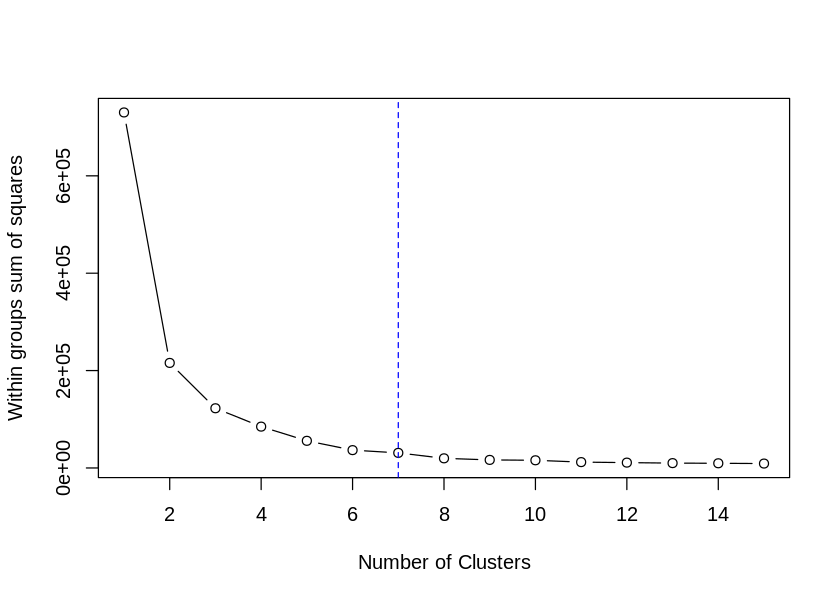

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)
wss <- (nrow(colData(se)$umap)-1) * sum(apply(colData(se)$umap, 2, var))
for (i in 2:15) wss[i] <- sum(kmeans(colData(se)$umap,centers = i, nstart = 10)$withinss)
options(repr.plot.width=7, repr.plot.height=5)
plot(1:15, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares")
n_cluster <- 7
abline(v = n_cluster, col = 'blue', lty = 2)

In [ ]:
set.seed(1)
# it is important to set nstart to a large number to get a relatively robust clustering result. 
cls <- kmeans(colData(se)$umap, n_cluster, nstart = 100)$cluster
table(cls, colData(se)$group)
cls <- as.numeric(factor(cls, c(4, 5, 2, 3, 1, 7, 6)))
table(cls, colData(se)$group)

   
cls MEF_NoDox MEF_Dox_D1 MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1         1          0         17        1493           3
  2         0          6       1443           1           0
  3         0          4       1435          23           0
  4      2878        541         21           2           3
  5       657        381          1           0           0
  6         0          2          0           1         813
  7        26         14         19        5682           8

   
cls MEF_NoDox MEF_Dox_D1 MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1      2878        541         21           2           3
  2       657        381          1           0           0
  3         0          6       1443           1           0
  4         0          4       1435          23           0
  5         1          0         17        1493           3
  6        26         14         19        5682           8
  7         0          2          0           1         813

# Seurat: converting Single cell experiment to seurat object

In [ ]:
system("wget -x -c -nH https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = readRDS(file = "gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = as(sce, "SingleCellExperiment")
print(sce)
rownames(sce) = rowData(sce)$name
colnames(sce)  = colData(sce)$barcodes
so = as.Seurat(sce, data = NULL)
so = CreateSeuratObject(counts = GetAssayData(so, slot = "counts"), meta.data = so@meta.data)
so[["percent.mt"]] = PercentageFeatureSet(so, pattern = "^mt-")
so[["percent.rpl"]] = PercentageFeatureSet(so, pattern = "^Rpl")
so[["percent.rps"]] = PercentageFeatureSet(so, pattern = "^Rps")
s.genes <- cc.genes$s.genes %>% str_to_title()
g2m.genes <- cc.genes$g2m.genes %>% str_to_title()
so <- CellCycleScoring(so, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
#normalize and scaling#
rownames(sce) = rownames(so)
colnames(sce) = colnames(so)
so <- SetAssayData(object = so, slot = "scale.data", new.data = assays(sce)$scaled_counts)
so <- SetAssayData(object = so, slot = "data", new.data = assays(sce)$normalized_counts)
#assign UMAP #
so[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(so@meta.data[,c("umap.V1", "umap.V2")]), key = "umap_", assay = DefaultAssay(so))
so

class: SingleCellExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique cell names (colnames) present in the input matrix, making unique”
Warning message:
“The following features are not present in the object: Mlf1ip, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: Fam64a, Hn1, not searching for symbol synonyms”


An object of class Seurat 
17010 features across 15475 samples within 1 assay 
Active assay: RNA (17010 features, 0 variable features)
 1 dimensional reduction calculated: umap

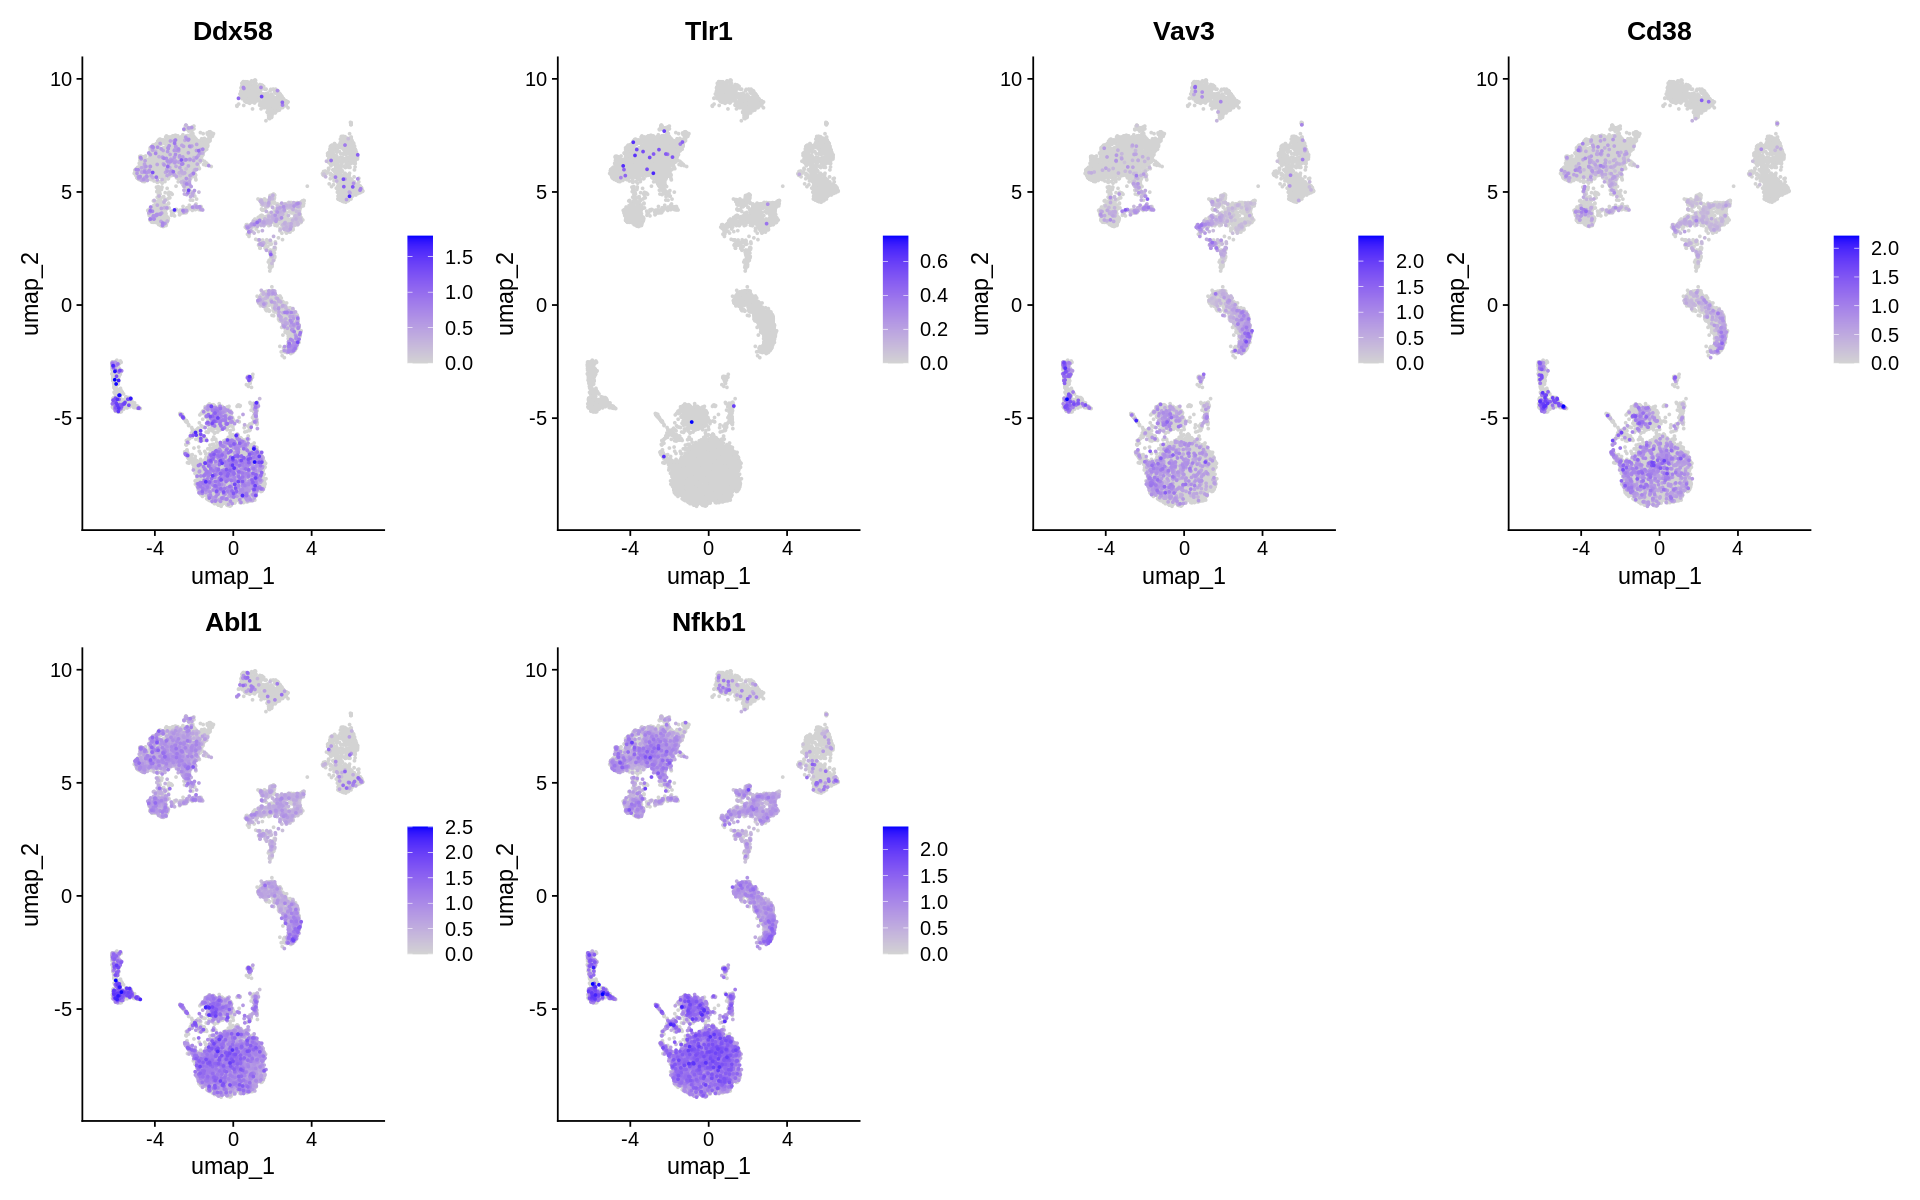

In [ ]:
options(repr.plot.width=16, repr.plot.height=10)
FeaturePlot(so,  features = c('Ddx58', 'Tlr1','Vav3','Cd38', 'Abl1','Nfkb1'), pt.size = 0.4, cols = c('lightgrey', "blue"), ncol = 4,  order = TRUE)

In [ ]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] SeuratObject_4.0.2                       
 [2] Seurat_4.0.4                             
 [3] SingleCellExperiment_1.14.1              
 [4] Mus.musculus_1.3.1                       
 [5] OrganismDbi_1.34.0                       
 [6] GOfunc

In [ ]:
Sys.time() - start_time0

Time difference of 31.75558 mins